In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))

TOTAL_NUM_DAYS = len(daydic)

## Tilt Properties - Ensure they're using the same depth range

In [12]:
def pav(xx, yy, zz):

    d_range = (-1000 <= zz) & (zz <= -200)

    xx = xx[d_range]
    yy = yy[d_range]
    zz = zz[d_range]

    centroid = np.mean(np.column_stack((xx, yy, zz)), axis=0)
    mean_centered_data = np.column_stack((xx - centroid[0], yy - centroid[1], zz - centroid[2]))
    cov_matrix = np.cov(mean_centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    principal_axis = sorted_eigenvectors[:, 0]
    
    if principal_axis[2] < 0:
        principal_axis = -principal_axis

    df = pd.DataFrame({
        'x': [centroid[0], principal_axis[0]],
        'y': [centroid[1], principal_axis[1]],
        'z': [centroid[2], principal_axis[2]]
    }, index=['Centroid', 'Principal Axis'])
    
    return df

def true_bearing(x, y):
    angle_rad = math.atan2(y, x)
    angle_deg = math.degrees(angle_rad)
    true_bearing = (90 - angle_deg) % 360
    return true_bearing

def tilt_distance(d_vec, z_btm):

    if z_btm <= -1000:
        z_btm = -1000
    z_top = -200 #-200

    TD = (z_top-z_btm)/d_vec[2]*np.sqrt(d_vec[0]**2+d_vec[1]**2)

    return TD

def calculate_r_squared(x, y, z, point_on_line, direction_vector):
    
    d_range = (-1000 <= z) & (z <= -200)

    x = x[d_range]
    y = y[d_range]
    z = z[d_range]

    def perpendicular_distances(x_coords, y_coords, z_coords, point_on_line, direction_vector):
        Q = np.array(point_on_line)
        d = np.array(direction_vector)
        direction_vector_magnitude = np.linalg.norm(d)
        distances = []
        for x, y, z in zip(x_coords, y_coords, z_coords):
            P = np.array([x, y, z])
            PQ = P - Q
            cross_product = np.cross(PQ, d)
            cross_product_magnitude = np.linalg.norm(cross_product)
            distance = cross_product_magnitude / direction_vector_magnitude
            distances.append(distance)
        return distances

    TSS = np.sum((np.array(x)-np.mean(x))**2 + (np.array(y)-np.mean(y))**2 +(np.array(z)-np.mean(z))**2)
    SSD = np.sum(np.array(perpendicular_distances(x, y, z, point_on_line, direction_vector))**2)
    r_squared = 1 - SSD/TSS

    return r_squared

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

In [15]:
def cow(eddy):

    SEARCH_RADIUS_MAX = 50000
    WIDTH, LENGTH = lon_rho.shape
    CURSPEED_THRESH = 0.05
    OW_THRESH = -2e-11
    RATIO_THRESH = 2/3
    
    calc_depths = z_r[150, 150, :]

    tilt_dfs = []
    PAVs = []
    brngs = []
    TDs = []
    R2s = []

    previous_file_idx = -1    
    for t in range(TOTAL_NUM_DAYS):

        if 'Day'+ str(t+1) in eddies[eddy].index:
            
            eddy_at_surface = [eddies[eddy].loc['Day' + str(t + 1)].Lon, eddies[eddy].loc['Day' + str(t + 1)].Lat]
            PREVIOUS_CENTER = eddy_at_surface

            R = np.sqrt((lon_rho - eddy_at_surface[0])**2 + (lat_rho - eddy_at_surface[1])**2)
            i_search, j_search = np.argwhere(R == np.min(R))[0]
        
            theta0 = np.deg2rad(lon_rho[i_search, j_search])
            phi0 = np.deg2rad(lat_rho[i_search, j_search])

            vert_centers = []
            PAV = []
            brng = []
            TD = []
            R2 =[]
            pots = []
            radii = []

            t_mod = t % 30
            file_idx = np.floor(t/30)
            if file_idx != previous_file_idx:
                fnumber = '0'+str(round(1461+ file_idx*30))
                ow = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
                cur_speed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
                previous_file_idx = file_idx

            for i, depth in enumerate(calc_depths):

                SEARCH_RADIUS = 5000
                potential = {}
                flag = 1
                while flag:
        
                    R = distance(PREVIOUS_CENTER[1], PREVIOUS_CENTER[0], lat_rho, lon_rho)
                    mask = R < SEARCH_RADIUS
                
                    cur_speed_masked = np.where(mask, cur_speed[:,:,i, t_mod], np.nan) 
                    ow_masked = np.where(mask, ow[:,:,i, t_mod], np.nan) 
                
                    pot_i, pot_j = np.where((cur_speed_masked < CURSPEED_THRESH) & (ow_masked < OW_THRESH))

                    if len(pot_i) != 0:
                        ratio = len(pot_i)/sum(sum(mask))
                    else:
                        ratio = 0
                    
                    if len(pot_i) > 0 or depth >= -6:
                        if ratio <= RATIO_THRESH and ratio != 0:
                            X = [lon_rho[pot_i, pot_j], lat_rho[pot_i, pot_j]]
                            C = np.mean(X, axis=1)
                            PREVIOUS_CENTER = C
                            vert_centers.append((C[0], C[1]))
                            flag = 0 
                        elif SEARCH_RADIUS <= SEARCH_RADIUS_MAX:
                            SEARCH_RADIUS += 5000
                        else:
                            vert_centers.append((np.nan, np.nan))
                            flag = 0
                    else:
                        flag = 0
                
                pots.append(potential)
                radii.append(SEARCH_RADIUS)

            lon = [tup[0] for tup in vert_centers]
            lat = [tup[1] for tup in vert_centers]
            
            lon_series = pd.Series(lon)
            lat_series = pd.Series(lat)
            
            first_non_nan = lon_series.first_valid_index()
            last_non_nan = lon_series.last_valid_index()
            
            if first_non_nan is not None and last_non_nan is not None:
                lon_series = lon_series[first_non_nan:last_non_nan].interpolate()
                lat_series = lat_series[first_non_nan:last_non_nan].interpolate()

                pots = pots[first_non_nan:last_non_nan]
                radii = radii[first_non_nan:last_non_nan]
                
                calculated_depths = calc_depths[first_non_nan:last_non_nan]

                if any(calculated_depths<=-400): 

                    d_range = (-1000 <= calculated_depths) & (calculated_depths <= -200)
                    pav_depths = calculated_depths[d_range]

                    lon = lon_series.tolist()
                    lat = lat_series.tolist()
                    
                    if len(pav_depths) > 1:
                        lonr = np.deg2rad(lon)
                        latr = np.deg2rad(lat)
                        r_earth = 6371000
                        
                        x = r_earth * np.cos(phi0) * (lonr - theta0)
                        y = r_earth * (latr - phi0)

                        pots_xy = []
                        for pot_lvl in pots:

                            poti = [t[0] for t in pot_lvl]
                            potj = [t[1] for t in pot_lvl]

                            pot_lonr = np.deg2rad(lon_rho[poti,potj])
                            pot_latr = np.deg2rad(lat_rho[poti,potj])

                            pot_x = r_earth * np.cos(phi0) * (pot_lonr - theta0)
                            pot_y = r_earth * (pot_latr - phi0)

                            pot_lvl_xy = set(zip(pot_x,pot_y))
                            pots_xy.append(pot_lvl_xy)
            
                        df = pd.DataFrame({
                            'lon': lon,
                            'lat': lat,
                            'x': x,
                            'y': y,
                            'depth': calculated_depths,
                            'pots': pots_xy,
                            's_radii': radii
                        }, index=list(range(len(calculated_depths))))
                        
                        if any(calculated_depths <= -400):  
                            
                            PAV = pav(df.x, df.y, df.depth)
                            brng = true_bearing(PAV.loc['Principal Axis'].x, PAV.loc['Principal Axis'].y)
                            d_vec = (PAV.loc['Principal Axis'].x, PAV.loc['Principal Axis'].y, PAV.loc['Principal Axis'].z)
                            z_btm = calculated_depths[-1]
                            TD = tilt_distance(d_vec, z_btm)
                            R2 = calculate_r_squared(x, y, calculated_depths, PAV.loc['Centroid'], PAV.loc['Principal Axis'])

                            if TD < 500000:  
                                tilt_dfs.append(df)
                                PAVs.append(PAV)
                                brngs.append(brng)
                                TDs.append(TD)
                                R2s.append(R2)
                            else:
                                tilt_dfs.append(np.nan)
                                PAVs.append(np.nan)
                                brngs.append(np.nan)
                                TDs.append(np.nan)     
                                R2s.append(np.nan)                     
                        else:
                            tilt_dfs.append(np.nan)
                            PAVs.append(np.nan)
                            brngs.append(np.nan)
                            TDs.append(np.nan)
                            R2s.append(np.nan) 
                    else:
                        tilt_dfs.append(np.nan)
                        PAVs.append(np.nan)
                        brngs.append(np.nan)
                        TDs.append(np.nan)
                        R2s.append(np.nan) 
                else:
                    tilt_dfs.append(np.nan)
                    PAVs.append(np.nan)
                    brngs.append(np.nan)
                    TDs.append(np.nan)
                    R2s.append(np.nan) 
            else:
                tilt_dfs.append(np.nan)
                PAVs.append(np.nan)
                brngs.append(np.nan)
                TDs.append(np.nan)
                R2s.append(np.nan) 

    # Update eddies dictionary with computed values
    eddies[eddy]['Sub Centers'] = tilt_dfs
    eddies[eddy]['Tilt PAV'] = PAVs
    eddies[eddy]['Tilt Bearing'] = brngs
    eddies[eddy]['Tilt Distance'] = TDs
    eddies[eddy]['R2'] = R2s

def tilt_plot(eddies, eddy, day, max_depth):

    def plot_line_given_point_and_direction_2d(point, direction, ax=None):
        if ax is None:
            ax = plt.gca()
        x_values = np.linspace(-25000, 25000, 400)
        y_values = point[1] + (x_values - point[0]) * (direction[1] / direction[0])
        ax.plot(x_values, y_values, color='k')
        ax.scatter(point[0], point[1], color='k', zorder=5)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    tilt_df = eddies[eddy].loc[day]['Sub Centers']
    tilt_PAV = eddies[eddy].loc[day]['Tilt PAV']

    if isinstance(tilt_PAV, pd.DataFrame):
        centroid = tilt_PAV.loc['Centroid']
        Paxis = tilt_PAV.loc['Principal Axis']
        plot_line_given_point_and_direction_2d([centroid.x, centroid.z], [Paxis.x, Paxis.z], ax=ax1)

        for i, p_lvl in enumerate(tilt_df.pots):
            potx = [t[0] for t in p_lvl]
            ax1.scatter(potx, [tilt_df.depth[i]] * len(potx))
   
        ax1.plot(tilt_df.x, tilt_df.depth, linewidth = 4)
        ax1.set_xlabel('x')
        ax1.set_ylabel('Depth')
        ax1.set_ylim([max_depth, 0])

        plot_line_given_point_and_direction_2d([centroid.y, centroid.z], [Paxis.y, Paxis.z], ax=ax2)

        for i, p_lvl in enumerate(tilt_df.pots):
            poty = [t[1] for t in p_lvl]
            ax2.scatter(poty, [tilt_df.depth[i]] * len(poty))

        ax2.plot(tilt_df.y, tilt_df.depth, linewidth = 4)
        ax2.set_xlabel('y')
        ax2.set_ylabel('Depth')
        ax2.set_ylim([max_depth, 0])

    fig.suptitle(f'{eddy} {day} R2={round(eddies[eddy].loc[day].R2,2)}')

    plt.show()


In [16]:
EDDY = 'Eddy15'  #'Eddy1230'

cow(EDDY)

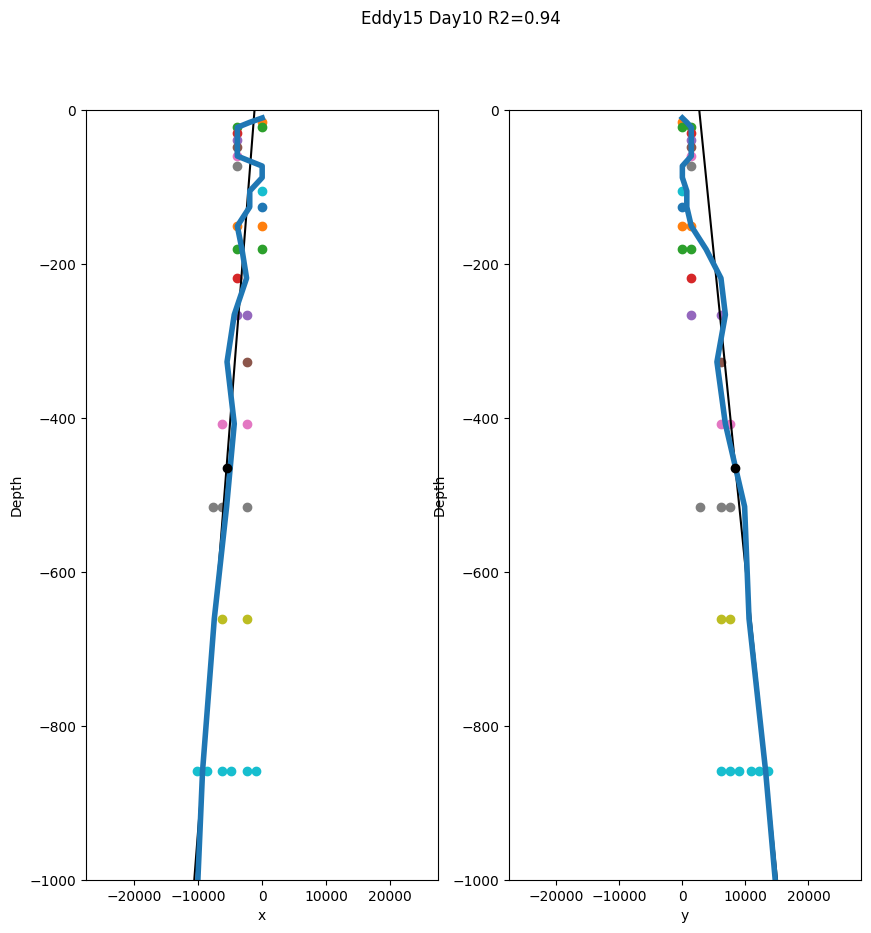

In [17]:
tilt_plot(eddies, EDDY, 'Day10', -1000)

In [7]:
import matplotlib.patheffects as path_effects

def plot_tilt_overview(eddy):

    def destination_point(lon, lat, distance, bearing):
        R = 6371000
        bearing = math.radians(bearing)
        lat1 = math.radians(lat)
        lon1 = math.radians(lon)
        lat2 = math.asin(math.sin(lat1) * math.cos(distance / R) +
                        math.cos(lat1) * math.sin(distance / R) * math.cos(bearing))
        lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(distance / R) * math.cos(lat1),
                                math.cos(distance / R) - math.sin(lat1) * math.sin(lat2))
        lat2 = math.degrees(lat2)
        lon2 = math.degrees(lon2)
        return lon2, lat2

    plt.figure(figsize=(10, 10))

    ax = plt.contourf(lon_rho, lat_rho, h)
    plt.colorbar(ax)


    flag = 1
    for time in range(TOTAL_NUM_DAYS):

        if 'Day'+str(time+1) in eddies[eddy].index:

            elon = eddies[eddy].loc['Day'+str(time+1)].Lon
            elat = eddies[eddy].loc['Day'+str(time+1)].Lat
            distance = eddies[eddy].loc['Day'+str(time+1)]['Tilt Distance']
            bearing = eddies[eddy].loc['Day'+str(time+1)]['Tilt Bearing']
            bearing = (bearing + 180) % 360 
            lon_btm, lat_btm = destination_point(elon, elat, distance, bearing)
            if eddies[eddy].loc['Day'+str(time+1)].R2 >= .9:
                plt.plot([elon, lon_btm], [elat, lat_btm], linewidth=3)
                plt.scatter(elon, elat)
            else:
                plt.scatter(elon, elat, facecolors='none', edgecolors='k')

            if not np.isnan(elon) and flag:
                text = plt.text(elon,elat,round(eddies[eddy].Id[0]),color='w',fontweight='bold')
                text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
                flag = 0
            
    plt.axis('equal')

    # plt.ylim([-40, -26])
    # plt.xlim([150, 161])

    plt.ylim([-38, -34])
    plt.xlim([150, 154])


    plt.show()

/scratch/pbs.5628581.kman.restech.unsw.edu.au/ipykernel_306899/2162693910.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = plt.text(elon,elat,round(eddies[eddy].Id[0]),color='w',fontweight='bold')


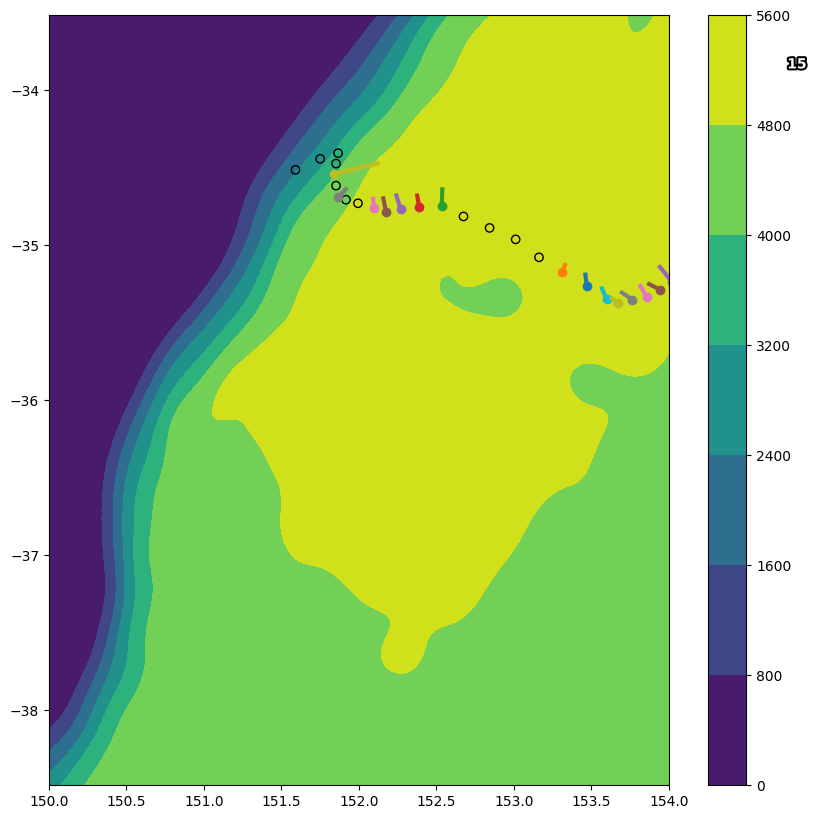

In [8]:
plot_tilt_overview(EDDY)

In [9]:
def pav_for_optimisation_search(xx, yy, zz):

    centroid = np.mean(np.column_stack((xx, yy, zz)), axis=0)
    mean_centered_data = np.column_stack((xx - centroid[0], yy - centroid[1], zz - centroid[2]))
    cov_matrix = np.cov(mean_centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    principal_axis = sorted_eigenvectors[:, 0]
    
    if principal_axis[2] < 0:
        principal_axis = -principal_axis

    df = pd.DataFrame({
        'x': [centroid[0], principal_axis[0]],
        'y': [centroid[1], principal_axis[1]],
        'z': [centroid[2], principal_axis[2]]
    }, index=['Centroid', 'Principal Axis'])
    
    return df

def perpendicular_distances(x_coords, y_coords, z_coords, point_on_line, direction_vector):
        Q = np.array(point_on_line)
        d = np.array(direction_vector)
        direction_vector_magnitude = np.linalg.norm(d)
        distances = []
        for x, y, z in zip(x_coords, y_coords, z_coords):
            P = np.array([x, y, z])
            PQ = P - Q
            cross_product = np.cross(PQ, d)
            cross_product_magnitude = np.linalg.norm(cross_product)
            distance = cross_product_magnitude / direction_vector_magnitude
            distances.append(distance)
        return distances

def adjust_index_vector(index_vector, vector_length):
    index_array = np.array(index_vector, dtype=bool)
    current_length = len(index_array)
    
    if current_length > vector_length:
        # Truncate the index vector
        return index_array[:vector_length]
    else:
        # Pad the index vector with False values
        padding = np.zeros(vector_length - current_length, dtype=bool)
        return np.concatenate((index_array, padding))

def find_subvector_indices(vector, subvector):
    vector = np.array(vector)
    subvector = np.array(subvector)
    len_vec = len(vector)
    len_subvec = len(subvector)
    
    result = [0] * len_vec
    for i in range(len_vec - len_subvec + 1):
        if np.array_equal(vector[i:i+len_subvec], subvector):
            result[i:i+len_subvec] = [1] * len_subvec
    return result

In [10]:
rmse_dic = {}

depths = z_r[150,150,:]

for d_id in range(23):

    top_depth = depths[d_id]
    btm_depth = -1000

    rmse = [0]*len(depths)

    counter = [0]*len(depths)

    eddy = EDDY

    for day in eddies[eddy].index:

        if not np.isnan(eddies[eddy].loc[day]['R2']):


            eddy_depths = eddies[eddy].loc[day]['Sub Centers'].depth

            d_range_measured = (btm_depth <= eddy_depths) & (eddy_depths <= top_depth)

            eddy_depths_measured = eddy_depths[d_range_measured]

            perp_d_sectioned = [0]*len(depths)

            if sum(d_range_measured) > 1:

                x = eddies[eddy].loc[day]['Sub Centers'].x[d_range_measured]
                y = eddies[eddy].loc[day]['Sub Centers'].y[d_range_measured]
                z = eddies[eddy].loc[day]['Sub Centers'].depth[d_range_measured] 


                pav_df = pav_for_optimisation_search(x,y,z)

                point_on_line = pav_df.loc['Centroid']
                direction_vector = pav_df.loc['Principal Axis']

                perp_d_eddy = perpendicular_distances(x, y, z, point_on_line, direction_vector)

                measured_idxs = find_subvector_indices(depths, eddy_depths_measured)

                index = 0
                for i in range(len(perp_d_sectioned)):
                    if measured_idxs[i] == 1:
                        perp_d_sectioned[i] = perp_d_eddy[index]
                        index += 1

                rmse = rmse + np.array(perp_d_sectioned)**2

                counter = [counter[i] + measured_idxs[i] for i in range(len(counter))]


    rmse = np.sqrt(np.array(rmse)/np.array(counter))

    rmse_df = pd.DataFrame({
        'RMSE': rmse,
        'Count': counter,
        'Depth': depths
    })

    rmse_dic['DepthID '+str(d_id)] = rmse_df



/scratch/pbs.5628581.kman.restech.unsw.edu.au/ipykernel_306899/1151231496.py:56: RuntimeWarning: invalid value encountered in divide
  rmse = np.sqrt(np.array(rmse)/np.array(counter))


Text(0, 0.5, 'Depth (m)')

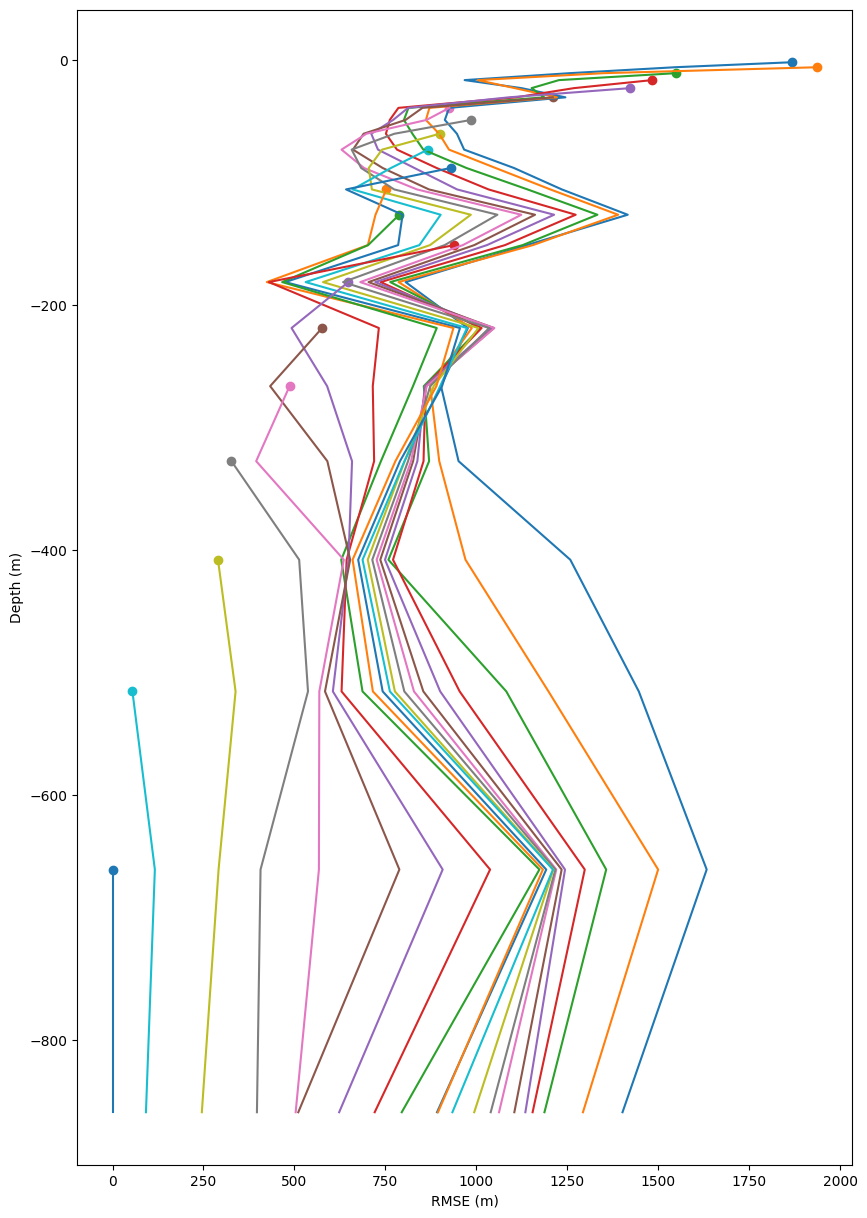

In [11]:
plt.figure(figsize=[10,15])

for depth_id in rmse_dic.keys():

    rmse_d = rmse_dic[depth_id].RMSE

    depth_d = rmse_dic[depth_id].Depth

    df = pd.DataFrame({'rmse_d': rmse_d, 'depth_d': depth_d})

    # Drop rows where rmse_d is NaN
    df_clean = df.dropna(subset=['rmse_d'])

    # Extract the cleaned depth_d column
    depth_d_clean = df_clean['depth_d']

    rmse_d_clean = rmse_d.dropna()

    plt.plot(rmse_d_clean, depth_d_clean)

    if list(rmse_d_clean):
        plt.scatter(list(rmse_d_clean)[0], list(depth_d_clean)[0])


plt.xlabel('RMSE (m)')
plt.ylabel('Depth (m)')